# Unsupervised learning on atomic structures

**Author**: Angelo Ziletti     
**Abstract**: In this tutorial, we will use unsupervised learning to perform exploratory analysis of atomic structures downloaded from a condensed-matter-physics/materials science data repository called NOMAD via a query (see [here](https://nomad-lab.eu/prod/rae/gui/search)).    
Specifically, we will represent its atomic structure via SOAP descriptor ([paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.184115)), a state-of-the-art structural representation for atomic structures. We will leverage the [DScribe](https://singroup.github.io/dscribe/latest/)).    
After the representation is performed, we will perform non-linear dimensionaliy reduction and clustering, with the goal of making a structural-similarity map of the atomic structures in the dataset.    
In such map, structures that are similar with each other will be clustered together, and will also appear closeby in the map.



<a href="https://colab.research.google.com/github/angeloziletti/data-science-physics/blob/main/load_nomad_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependencies and mount Google Drive (only if you run with Colab)
(uncomment the two cells below)

In [ ]:
# uncomment the line below if you run the code on Colab
#%pip install umap-learn hdbscan dscribe numpy ase notebook umap-learn[plot]

In [4]:
# uncomment the lines below if you run the code on Colab
#from google.colab import drive
#drive.mount('/content/gdrive')

Import neeeded libraries

In [1]:
import json
import logging
import os
from os import listdir
from os.path import isfile, join

import hdbscan
import numpy as np
import pandas as pd
import umap
import umap.plot
from ase import Atoms
from ase.io import write
from ase.visualize import view
from dscribe.descriptors import SOAP

# create basic logging
logging.basicConfig(level=logging.INFO)

Define the folder where you stored the data

In [2]:
# local path (example)
main_path = r"C:\Users\angel\OneDrive\Teaching\ds-physics-unicatt-data"
# possible path on Gdrive
#main_path = r"/content/gdrive/My Drive/data-science-physics-data/"

data_folder = os.path.join(main_path, "2d_materials_nomad")
out_folder = os.path.join(main_path, "output")

In [3]:
# let us create the output folder first
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    logging.info("Output folder created at {}".format(out_folder))
else:
    logging.info("Output folder already present at {}".format(out_folder))

matrix_filename = (os.path.join(out_folder, "soap_matrix.npy"))

# put this to false if you have already pre-computed the SOAP descriptor (to save time)
compute_desc = True

INFO:root:Output folder already present at C:\Users\angel\OneDrive\Teaching\ds-physics-unicatt-data\output


In [4]:
json_files = [filename for filename in listdir(data_folder) if isfile(join(data_folder, filename))]
json_files_path = [join(data_folder, filename) for filename in json_files]

logging.info("Files found: {}".format(len(json_files)))

def create_ase_structure(system):
    """Read and convert the structures to ASE atoms structures""" 
    positions = system["atom_positions"]
    pbc = system["configuration_periodic_dimensions"]
    atom_labels = system["atom_labels"]
    cell = np.multiply(system["simulation_cell"], 1.e+10)
    atoms = Atoms(atom_labels, positions=positions, cell=cell, pbc=pbc)
    return atoms

# loop over the files, and extract one atomic configuration
atoms_list = []
for idx_json_file, json_file in enumerate(json_files_path):
    with open(json_file) as f:
        data = json.load(f)
        if "section_run" in data.keys():
            section_run = data["section_run"][0]

            if "section_system" in section_run.keys():
                system = section_run["section_system"][0]
                atoms = create_ase_structure(system)
                atoms_list.append(atoms)

logging.info("Obtained list of {} structures".format(len(atoms_list)))

INFO:root:Files found: 132
INFO:root:Obtained list of 131 structures


Let us visualize one atomic structure

In [5]:
# create a supercell for visualization purposes
supercell = (3, 3, 3)
view(atoms_list[5]*supercell, viewer='x3d')

We need to find which atomic elements appear in the atomic structures. This is a requirement for the SOAP calculation.

In [6]:
elements = []
def get_all_el(atoms_list):
    """Obtain all atomic elements appearing in the structures"""
    elements = []
    for atoms in atoms_list:
        elements.extend(atoms.get_chemical_symbols())
    return elements

# get all possible atomic species
species = get_all_el(atoms_list)

We now perform the calculation of the SOAP descriptor using the DScribe package.

In [7]:
def get_soap_from_atoms(atoms, species, rcut=2., lmax=3, nmax=3):
    """From a structure, calculate its SOAP descriptor"""
    soap = SOAP(
    species=species,
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    periodic=atoms.get_pbc().any(),
    sparse=False,
    average="inner")

    soap_atoms = soap.create(atoms)

    return soap_atoms

if compute_desc:
    # compute the soap descriptor if you have not done so already
    soap_vectors = []
    for idx_atoms, atoms in enumerate(atoms_list):
        if idx_atoms % (int(len(atoms_list) / 10) + 1) == 0:
            logging.info("Calculating descriptor:  {0}/{1}".format(idx_atoms + 1, len(atoms_list)))
        soap_vector = get_soap_from_atoms(atoms, species)
        soap_vectors.append(soap_vector)

    soap_matrix = np.asarray(soap_vectors).reshape((len(atoms_list), -1))

    logging.info("SOAP matrix shape: {}".format(soap_matrix.shape))

    hover_data = pd.DataFrame({'index':np.arange(len(atoms_list))})


    with open(matrix_filename, 'wb') as fileout:
        np.save(fileout, soap_matrix)
        logging.info("SOAP matrix saved at {}".format(matrix_filename))

else:
    with open(matrix_filename, 'rb') as filein:
        logging.info("Loading SOAP matrix from {}".format(matrix_filename))
        soap_matrix = np.load(filein)

INFO:root:Calculating descriptor:  1/131
INFO:root:Calculating descriptor:  15/131
INFO:root:Calculating descriptor:  29/131
INFO:root:Calculating descriptor:  43/131
INFO:root:Calculating descriptor:  57/131
INFO:root:Calculating descriptor:  71/131
INFO:root:Calculating descriptor:  85/131
INFO:root:Calculating descriptor:  99/131
INFO:root:Calculating descriptor:  113/131
INFO:root:Calculating descriptor:  127/131
INFO:root:SOAP matrix shape: (131, 14280)
INFO:root:SOAP matrix saved at C:\Users\angel\OneDrive\Teaching\ds-physics-unicatt-data\output\soap_matrix.npy


For convenience, let us arrange the data in a Panda DataFrame

In [8]:
def df_from_atoms(atoms_list):
    """Convert atoms in panda DataFrame for convenience"""
    formulas = []
    idxs = []
    for idx_atoms, atoms in enumerate(atoms_list):
        formula = atoms.get_chemical_formula()
        formulas.append(formula)
        idxs.append(idx_atoms)

    df_atoms = pd.DataFrame({'index':idxs, 'chem_formula':formulas})

    return df_atoms

df_atoms = df_from_atoms(atoms_list)

Let us perform a non-linear dimensionality reduction with UMAP before clustering is performed. This usually facilitate clustering, because now the data will reside in a lower dimensional space. 
In this case, we choose 10 dimensions.

In [9]:
# reduce dimensionality to facilitate clustering 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=10)
soap_matrix_reduced = reducer.fit_transform(soap_matrix)
logging.info("Reduced dimensionality to: {}".format(soap_matrix_reduced.shape))

INFO:root:Reduced dimensionality to: (131, 10)


We now compute the clustering using HDBSCAN

In [10]:
# compute clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_method='leaf')
clusterer.fit(soap_matrix_reduced)
labels = clusterer.labels_

df_atoms['cluster'] = labels

The clustering labels are now in the Panda Dataframe. 
For visualization purposes, we want to plot the data in a map, so that we can explore the similarity between our atomic structures on a two-dimensional map.

To this end, we perform an additional dimensionality reduction, this time to two dimensions:

In [11]:
# reduce to two dimensions for plotting purposes
mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2).fit(soap_matrix_reduced)

Finally, we show the results in a map:

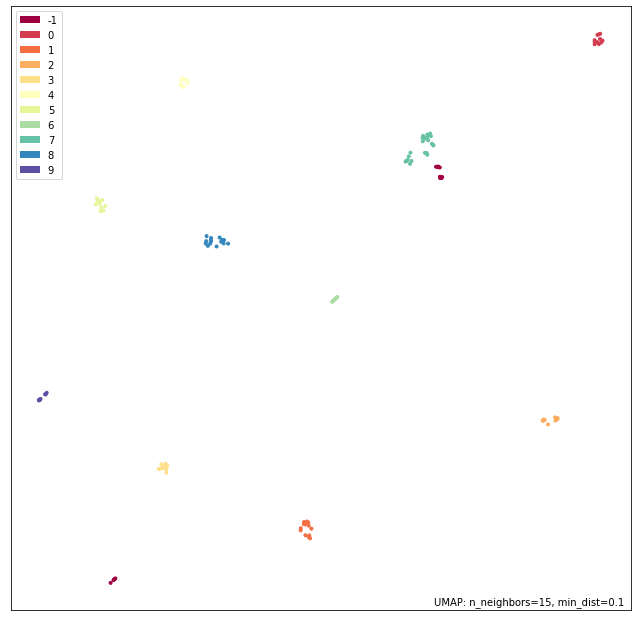

In [12]:
umap.plot.points(mapper, labels=labels)
p = umap.plot.interactive(mapper, labels=labels, hover_data=df_atoms, point_size=10, background='black')

# show plot
umap.plot.show(p)

Structures that are similar to each others will appear close to each other in the structural-similarity map. Moreover, similar structures are clustered together by HDBSCAN (see colors)